This notebook template is designed for testing the performance of Rotatron environments and different solving agents of different scales.

In [3]:
# =============================================================================
# Work on local biobuild in GIT repo
# =============================================================================
import os, sys, importlib

# for inside python scripts
# base = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(__file__))))
base = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, base)

def reload_optimizers():
    importlib.reload(bam.optimizers.environments)
    importlib.reload(bam.optimizers.agents)
# =============================================================================
import files
import auxiliary
import buildamol as bam
import buildamol.optimizers.DistanceRotatron as DistanceRotatron
import buildamol.optimizers.algorithms as agents
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 
from collections import defaultdict

import time
import numpy as np
import pandas as pd

Here we can select which tests to run and on what testing structures:

In [4]:
# which structures to run on
structures_to_run_on = [
    # files.GLUCOSE2,
    files.PEPTIDE,
    # files.X_WING,
    # files.X_WING2,
    # files.SCAFFOLD1,
    # files.SCAFFOLD3,
]

# how many times to independently run on each structure
re_runs = 1

# visualize evaluation history
visualize_eval_history = True

# visualize time history
visualize_time_history = True

# visualise clashes in final structure
visualize_clashes = True

# clash threshold
clash_cutoff = 0.8

# visualize the final structure
visualize_final_structure = False

# visualization parameters
# for draw_edges()
visualization_params = dict(color="magenta", opacity=0.3)

# export visualization to html
export_visualization = False

# export solutions as PDB
export_pdb = True

# export history to csv
export_history = True

# export name prefix
export_name_prefix = None

# graph building function
# provide a custom callable that generates a tuple of (graph, rotatable_edges)
def make_graph(structure:bam.Molecule):
    graph = structure.get_atom_graph()
    # graph = structure.make_residue_graph()
    # graph.make_detailed(n_samples=0.5)
    edges = graph.find_rotatable_edges(min_descendants=20, min_ancestors=20)
    edges = graph.direct_edges(root_node=structure.get_atom("Cl1"), edges=edges, adopt=True)
    return graph, edges

graph_factory = make_graph

# graph building parameters
graph_params = {}

# provide a custom callable to set a custom building function for the environment
rotatron_factory = None

# the rotatron class to use
rotatron_class = DistanceRotatron

# rotatron parameters
rotatron_params = {"pushback": 4, "radius": -1}

# the agent function to use
# agent = agents.nelder_mead_optimize
# agent_params = {}
agent = agents.swarm_optimize
agent_params = {"max_steps":10, "n_particles":10, "variation" : 0.2}#{"bounds":(-np.pi/2, np.pi/2)}

# agent = agents.newton_like_optimize

# # agent parameters
# agent_params = {"max_steps" : 300}   


Perform some environment setup

In [5]:
if agent is None:
    raise ValueError("No agent provided")
if rotatron_class is None:
    raise ValueError("No rotatron class provided")
    
if graph_factory is None:
    graph_factory = auxiliary.graph_factory
if rotatron_factory is None:
    rotatron_factory = auxiliary.rotatron_factory

available_structures = {}

eval_history = defaultdict(list)
time_history = defaultdict(list)
clash_history = defaultdict(list)
final_visuals = {}
initial_evals = {}
initial_clashes = {}
v = None

if not export_name_prefix:
    export_name_prefix = rotatron_class.__name__ + "." + agent.__name__

def make_environment(structure):
    """
    An environment generator
    """
    graph, rotatable_edges = graph_factory(structure, **graph_params)
    return rotatron_factory(rotatron_class, graph, rotatable_edges, **rotatron_params)


Now start the main testing code

In [92]:
structure = bam.molecule(structures_to_run_on[0])

In [93]:
# structure.rotate_descendants(10, 24, 50)
structure.show()

In [103]:
edges = [(structure.get_atom(32), structure.get_atom(33))]
graph = structure.get_atom_graph()

env = DistanceRotatron(graph, edges, pushback=0.1)


env._best_eval, env._best_clashes, edges

(-1.9765138115921068, 0, [(Atom(CA, 32), Atom(C, 33))])

In [104]:
edges

[(Atom(CA, 32), Atom(C, 33))]

In [105]:
# def eval(self, state):  # , diff=True):
#         """
#         Calculate the evaluation score for a given state

#         Parameters
#         ----------
#         state : np.ndarray
#             The state of the environment

#         Returns
#         -------
#         float
#             The evaluation for the state
#         """
#         pairwise_dists = cdist(state, state)
#         np.fill_diagonal(pairwise_dists, self._radius + 1)

#         # if diff:
#         # mask = np.abs(pairwise_dists - self._state_dists) < 1e-4
#         # mask *= pairwise_dists > self.clash_distance
#         # pairwise_dists[mask] = self._radius + 1

#         # self.clash_handler()

#         rowwise_dist_eval = np.apply_along_axis(
#             self.concatenation_function, 1, pairwise_dists
#         )
#         mask = rowwise_dist_eval > -1
#         rowwise_dist_eval[mask] = self.n_nodes / (
#             (rowwise_dist_eval[mask] ** 3 + 1e-6)
#         ) 
#         rowwise_dist_eval[mask] = np.log(rowwise_dist_eval[mask])
#         if np.any(mask) == 1:
#             final = np.sum(rowwise_dist_eval[mask])
#             self._state_dists[:, :] = 0
#             self._state_dists += pairwise_dists
#         else:
#             final = self._last_eval
#         return final

# envs.DistanceRotatron.eval = eval


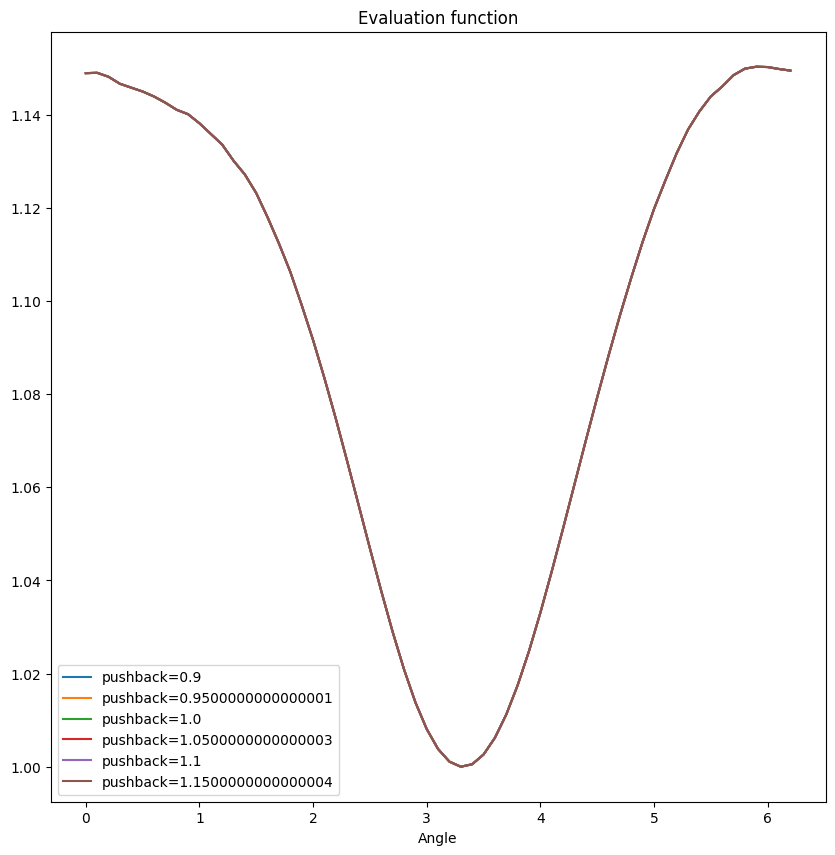

In [106]:

angles = np.arange(0, np.pi*2, 0.1)

pushbacks = np.arange(0.9, 1.2, 0.05)

fig, ax = plt.subplots(figsize=(10, 10))
for pushback in pushbacks:

    env = DistanceRotatron(graph, edges, radius=15, mask_rotation_units=True, pushback=pushback)

    evals = np.zeros_like(angles)

    idx = 0
    for angle in angles:
        state, eval, *_ = env.step([angle])
        evals[idx] = eval
        env.reset()
        idx += 1
    evals /= evals.max()
    ax = sns.lineplot(x=angles, y=evals, ax=ax, label=f"pushback={pushback}")
    ax.set_xlabel("Angle")
    ax.set_title("Evaluation function")


In [132]:
evals

array([1.05523745, 1.0545702 , 1.0538157 , 1.05440749, 1.05335686,
       1.05325486, 1.05435325, 1.05558942, 1.05786313, 1.06072819,
       1.06300157, 1.06558101, 1.06808637, 1.07087591, 1.07360495,
       1.07629743, 1.07993582, 1.07953211, 1.07868099, 1.07953533,
       1.07657855, 1.0732322 , 1.06789932, 1.06378969, 1.05663864,
       1.04959812, 1.04181811, 1.03308661, 1.02490914, 1.01762131,
       1.01146985, 1.00600178, 1.00215334, 1.00004363, 1.        ,
       1.00177979, 1.00524529, 1.01058383, 1.01748161, 1.02512986,
       1.03418697, 1.04340008, 1.05172285, 1.05977627, 1.06722343,
       1.07368392, 1.07785955, 1.08103169, 1.08133906, 1.08115814,
       1.08184464, 1.08230035, 1.07848201, 1.07706317, 1.07392103,
       1.07072118, 1.06738751, 1.06445516, 1.06288334, 1.06132508,
       1.05969426, 1.05745521, 1.056735  ])

Text(0.5, 1.0, 'Evaluation function')

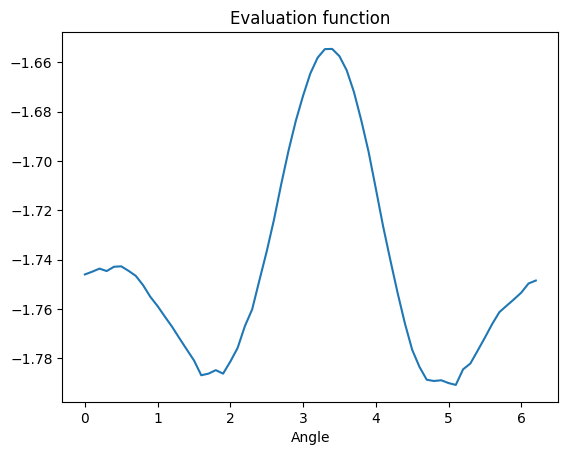

In [165]:

def eval(self, state):  # , diff=True):
    """
    Calculate the evaluation score for a given state

    Parameters
    ----------
    state : np.ndarray
        The state of the environment

    Returns
    -------
    float
        The evaluation for the state
    """
    pairwise_dists = cdist(state, state)
    np.fill_diagonal(pairwise_dists, self._radius)

    # if diff:
    #     mask = np.abs(pairwise_dists - self._state_dists) < 1e-4
    #     mask *= pairwise_dists > self.clash_distance
    #     pairwise_dists[mask] = self._radius + 1

    # self.clash_handler()

    dist_eval = np.apply_along_axis(self.concatenation_function, 1, pairwise_dists)
    mask = dist_eval > -1
    if not np.logical_or.reduce(mask):
        final = self._last_eval

    mean_dist_eval = np.mean(1/dist_eval[mask])
    # mean_dist_eval = 1 / np.mean(dist_eval[mask])
    # min_dist_eval = (np.min(pairwise_dists) ** self._pushback) + 1e-6

    final = np.log(mean_dist_eval)# / min_dist_eval)
    self._state_dists[:, :] = pairwise_dists
    self._last_eval = final
    return final


DistanceRotatron.eval = eval


angles = np.arange(0, np.pi*2, 0.1)


p = 2
def concat1(x):
    smallest = np.sum(np.sort(x)[:5])
    mean = np.mean(x)
    return (1 * mean + 0 * smallest)

# def concat1(x):
#     mean = np.mean(x)
#     min = np.min(x)
#     return (1.0 / mean) * (min ** p)
    # sortof promising
    # return (1.0 / mean) + (1.0 / min ** p)
env = DistanceRotatron(graph, edges, pushback=p, radius=10, concatenation_function=concat1, mask_rotation_units=False)#, concatenation_function=concat)

evals = np.zeros_like(angles)

idx = 0
for angle in angles:
    state, e, *_ = env.step([angle])
    evals[idx] = e
    env.reset()
    idx += 1
# evals /= evals.max()
ax = sns.lineplot(x=angles, y=evals)
ax.set_xlabel("Angle")
ax.set_title("Evaluation function")


In [162]:

angle = angles[np.argmin(evals)]
s = structure.copy()
s.rotate_descendants(32, 33, angle, angle_is_degrees=False)
v = s.draw()
v.draw_edges(*structure.bonds, color="lightblue")
v.show()

In [157]:
s.show()

In [66]:
env = DistanceRotatron(graph, edges, pushback=3, radius=20, concatenation_function=concat)

animation_frames = []
evals = np.zeros_like(angles)

idx = 0
for angle in angles:
    state, eval, *_ = env.step([angle])
    evals[idx] = eval
    env.reset()
    idx += 1

_e = -evals + evals.max()
_e = _e / _e.max()
for i, angle in enumerate(angles):
    v = env.graph.draw()
    s = structure.copy()
    s.rotate_descendants(32, 33, angle, angle_is_degrees=False)
    v.draw_edges(*s.bonds, color="blue", opacity = _e[i] ) 
    animation_frames.append(go.Frame(data=v.figure.data))

angle = angles[np.argmin(evals)]
s = structure.copy()
s.rotate_descendants(32, 33, angle, angle_is_degrees=False)
v.draw_edges(*s.bonds, color="green", opacity = 1)

animation_frames.append(go.Frame(data=v.figure.data))
v.show()

anim = go.Figure(
    data=v.figure.data,
    layout=v.figure.layout,
    frames=animation_frames,
)
anim.write_html("animation.html")

In [60]:
def eval(self, state):  # , diff=True):
        """
        Calculate the evaluation score for a given state

        Parameters
        ----------
        state : np.ndarray
            The state of the environment

        Returns
        -------
        float
            The evaluation for the state
        """
        pairwise_dists = cdist(state, state)
        np.fill_diagonal(pairwise_dists, self._radius)

        # if diff:
        #     mask = np.abs(pairwise_dists - self._state_dists) < 1e-4
        #     mask *= pairwise_dists > self.clash_distance
        #     pairwise_dists[mask] = self._radius + 1

        # self.clash_handler()

        dist_eval = np.apply_along_axis(
            self.concatenation_function, 1, pairwise_dists
        )
        mask = dist_eval > -1
        # mean_dist_eval = 1.0 / np.mean(dist_eval[mask])
        # min_dist_eval = 1.0 / (np.min(dist_eval[mask] ** self._pushback) + 1e-6)

        final = np.log(np.mean(dist_eval[mask]) / (np.min(pairwise_dists) ** self._pushback))
        self._state_dists[:, :] = pairwise_dists
        self._last_eval = final
        return final

        # rowwise_dist_eval = np.apply_along_axis(
        #     self.concatenation_function, 1, pairwise_dists
        # )
        # mask = rowwise_dist_eval > -1
        # if not np.logical_or.reduce(mask):
        #     return self._last_eval

        rowwise_dist_eval[mask] **= self._pushback
        rowwise_dist_eval[mask] += 1e-6
        rowwise_dist_eval[mask] /= self.n_nodes
        rowwise_dist_eval[mask] **= -1
        rowwise_dist_eval[mask] = np.log(rowwise_dist_eval[mask])

        final = np.sum(rowwise_dist_eval[mask])
        self._state_dists[:, :] = pairwise_dists
        self._last_eval = final
        return final

DistanceRotatron.eval = eval


p = 0.05
def concat1(x):
    return 1/np.mean(x)
    # mean = np.mean(x)
    # min = np.min(x)
    # return (1.0 / mean) * (min ** p)
    # sortof promising
    # return (1.0 / mean) + (1.0 / min ** p)
env = DistanceRotatron(graph, edges, pushback=p, radius=20, concatenation_function=concat1)#, concatenation_function=concat)

angles = np.arange(0, np.pi*2, 0.3)
evals = np.zeros_like(angles)

idx = 0
for angle in angles:
    state, eval, *_ = env.step([angle])
    evals[idx] = eval
    env.reset()
    idx += 1

cmap = sns.color_palette("RdBu", as_cmap=True)
color_to_hex = lambda x: f"rgb({int(x[0]*255)},{int(x[1]*255)},{int(x[2]*255)})"
v = env.graph.draw()
_e = -evals + evals.max()
_e = _e / _e.max()
for i, angle in enumerate(angles):
    s = structure.copy()
    s.rotate_descendants(32, 33, angle, angle_is_degrees=False)
    v.draw_edges(*s.bonds, color=color_to_hex(cmap(_e[i])), opacity=0.6) 

angle = angles[np.argmin(evals)]
s = structure.copy()
s.rotate_descendants(32, 33, angle, angle_is_degrees=False)
v.draw_edges(*s.bonds, color="limegreen", opacity = 1)

v.show()


In [61]:

angle = angles[np.argmin(evals)]
s = structure.copy()
s.rotate_descendants(32, 33, angle, angle_is_degrees=False)
v = s.draw()
v.draw_edges(*structure.bonds, color="lightblue")
v.show()

In [1]:
def eval(self, state):  # , diff=True):
        """
        Calculate the evaluation score for a given state

        Parameters
        ----------
        state : np.ndarray
            The state of the environment

        Returns
        -------
        float
            The evaluation for the state
        """
        pairwise_dists = cdist(state, state)
        np.fill_diagonal(pairwise_dists, self._radius)

        # if diff:
        #     mask = np.abs(pairwise_dists - self._state_dists) < 1e-4
        #     mask *= pairwise_dists > self.clash_distance
        #     pairwise_dists[mask] = self._radius + 1

        # self.clash_handler()

        dist_eval = self.concatination_function(pairwise_dists)
        mask = dist_eval > -1
        mean_dist_eval = 1.0 / np.mean(dist_eval[mask])
        min_dist_eval = 1.0 / (np.min(dist_eval[mask] ** self._pushback) + 1e-6)

        final = np.log(mean_dist_eval + min_dist_eval)
        self._state_dists[:, :] = pairwise_dists
        self._last_eval = final
        return final

        # rowwise_dist_eval = np.apply_along_axis(
        #     self.concatenation_function, 1, pairwise_dists
        # )
        # mask = rowwise_dist_eval > -1
        # if not np.logical_or.reduce(mask):
        #     return self._last_eval

        rowwise_dist_eval[mask] **= self._pushback
        rowwise_dist_eval[mask] += 1e-6
        rowwise_dist_eval[mask] /= self.n_nodes
        rowwise_dist_eval[mask] **= -1
        rowwise_dist_eval[mask] = np.log(rowwise_dist_eval[mask])

        final = np.sum(rowwise_dist_eval[mask])
        self._state_dists[:, :] = pairwise_dists
        self._last_eval = final
        return final

DistanceRotatron.eval = eval

NameError: name 'DistanceRotatron' is not defined

In [2]:

angles = np.arange(0, np.pi*2, 0.1)

def concat(x):
    return np.mean(x) - np.min(x)**2

for radius in range(15, 20, 1):
    env = DistanceRotatron(graph, edges, radius=radius, pushback=3, concatenation_function=concat)
    
    evals = np.zeros_like(angles)

    idx = 0
    for angle in angles:
        state, eval, *_ = env.step([angle])
        evals[idx] = eval
        env.reset()
        idx += 1
    evals /= evals.max()
    ax = sns.lineplot(x=angles, y=evals, label=radius)
    ax.legend(bbox_to_anchor=(1.05, 1)).set_title("radius")
    ax.set_title("radius effect")


NameError: name 'np' is not defined

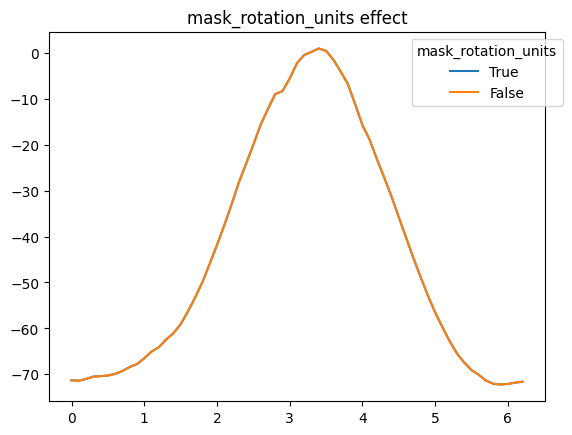

In [63]:
for i in (True, False):
    env = DistanceRotatron(graph, edges, mask_rotation_units=i, radius=15, concatenation_function=concat)

    evals = np.zeros_like(angles)

    idx = 0
    for angle in angles:
        state, eval, *_ = env.step([angle])
        evals[idx] = eval
        env.reset()
        idx += 1

    evals /= evals.max()
    ax = sns.lineplot(x=angles, y=evals, label=i)
    ax.legend(bbox_to_anchor=(1.05, 1)).set_title("mask_rotation_units")
    ax.set_title("mask_rotation_units effect")

In [115]:
graph = structure.get_atom_graph()
edges = graph.find_rotatable_edges(min_descendants=2)
env = DistanceRotatron(graph, edges, concatenation_function=concat)
v = structure.draw()
for i in range(5):
    final = bam.optimizers.quick_optimize(structure.copy())
    v.draw_edges(*final.bonds, color="red", opacity=0.3)


In [117]:

env = DistanceRotatron(graph, edges, concatenation_function=lambda x: np.mean(x) - np.min(x) **2)
for i in range(5):
    final = bam.optimizers.quick_optimize(structure.copy())
    v.draw_edges(*final.bonds, color="blue", opacity=0.3)
v.show()